In [7]:
import os

import numpy as np
import pandas as pd
import cvxpy as cp
from numba import jit

from sklearn.covariance import shrunk_covariance
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [8]:
FEATURES_DIR = './features'
FEATURES_DIR = os.path.abspath(FEATURES_DIR)
print (FEATURES_DIR)

c:\Users\Mirom\Desktop\FS\factor-stragedies\factor_stragedies\src\features


In [9]:
def neutralize(weights):
    return weights.sub(weights.mean(axis=1), axis=0)

def scale(weights):
    return weights.div(weights.abs().sum(axis=1), axis=0)

def truncate(weights, max_weight=0.05):
    return weights.clip(-max_weight, max_weight)

def truncate_and_normalize(weights, max_weight=0.05):
    weights = neutralize(weights)
    weights = scale(weights)
    for _ in range(5):
        weights = truncate(weights, max_weight)
        weights = neutralize(weights)
        weights = scale(weights)
    return weights

In [10]:
def ts_mean(df, window):
    return df.rolling(window).mean()

def ts_sum(df, window):
    return df.rolling(window).sum()

def ts_min(df, window):
    return df.rolling(window).min()

def ts_max(df, window):
    return df.rolling(window).max()

def ts_std(df, window):
    return df.rolling(window).std()

def ts_zscore(df, window):
    return (df - df.rolling(window).mean()) / df.rolling(window).std()

def cs_rank(df):
    return df.rank(axis=1, pct=1)

@jit(nopython=True)
def rank_of_last(arr):
    # returns rank of the last element in the series
    # `arr` is required to be of type numpy array
    x = arr[-1]
    
    if np.isnan(x):
        return np.nan
    
    g = np.sum(arr > x)
    l = np.sum(arr < x)
    eq = np.sum(arr == x)
    n = g + l + eq
    
    if n == 1:
        return 0.5
    
    return (l + 0.5 * (eq - 1)) / (n-1)

@jit(nopython=True)
def jit_ts_rank(M, window):
    height, width = M.shape
    R = np.zeros((height, width), dtype=np.float64)
    for j in range(width):
        for i in range(height):
            if i < window-1:
                R[i, j] = np.nan
            else:
                R[i, j] = rank_of_last(M[i-window+1:i+1, j])
    return R

def ts_rank(df, window):
    return pd.DataFrame(jit_ts_rank(df.values, window), index=df.index, columns=df.columns)

In [11]:
class Simulator:
    def __init__(self, features_dir, from_date=None, to_date=None, session_start_time=None, session_end_time=None):
        self.features_dir = features_dir
        self.dates = sorted(os.listdir(features_dir))
        if from_date is not None:
            self.dates = [date for date in self.dates if date >= from_date]
        if to_date is not None:
            self.dates = [date for date in self.dates if date <= to_date]
        self.feature_names = np.unique(np.concatenate([[os.path.splitext(filename)[0] for filename in os.listdir(os.path.join(self.features_dir, date))] for date in self.dates]))
        
        # filter out weekends and holidays based on trading activity
        trading_dates = list()
        for date in self.dates:
            if pd.read_parquet(os.path.join(FEATURES_DIR, date, 'trade_val.parquet')).sum(axis=0).sum() > 0:
                trading_dates.append(date)
        print ("Identified {} trading dates out of {}".format(len(trading_dates), len(self.dates)))
        self.dates = trading_dates
        self.tickers = None
        
        self.session_start_time = session_start_time
        self.session_end_time = session_end_time
        
        self.init_data()
        self.timeline_5m = self.data['trade_pr_close'].index
        
        self.init_tickers()
        self.init_universes()
        self.timeline_1d = self.universe_1d['all'].index
        
    def init_data(self):
        self.data = dict()
        
        # for stats calculation we must have feature `trade_pr_close`
        self.load_feature('trade_pr_close')
        self.load_feature('trade_val')
    
    def init_tickers(self):
        self.tickers = self.get_data('trade_pr_close').columns.tolist()
        
        trade_val = self.get_data('trade_val')
        total_trade_val = trade_val.sum(axis=0)
        ix = total_trade_val == 0
        if ix.sum():
            empty_tickers = total_trade_val[ix].index.tolist()
            print ("Identified tickers with empty history: {}: dropping".format(empty_tickers))
            self.tickers = np.setdiff1d(self.tickers, empty_tickers)
        
        # hard code
        manually_exclude_tickers = ['ACKO', 'GAZC', 'GAZS', 'GAZT', 'SVETP']
        self.tickers = np.setdiff1d(self.tickers, manually_exclude_tickers)
        
        self.data['trade_pr_close'] = self.data['trade_pr_close'][self.tickers]
        self.data['trade_val'] = self.data['trade_val'][self.tickers]
    
    def init_universes(self):
        trading_value = self.data['trade_val']
        daily_trading_value = trading_value.groupby(pd.to_datetime(trading_value.index.strftime('%Y-%m-%d'))).sum()
        trading_value_30days_rank = daily_trading_value.rolling(30, min_periods=1).sum().rank(axis=1, ascending=False)
        
        self.universe_1d = dict()
        for n in [25, 50, 100, 200]:
            self.universe_1d[f'top_{n}'] = (trading_value_30days_rank <= n).fillna(False)
        self.universe_1d['all'] = (trading_value_30days_rank <= trading_value_30days_rank.shape[1]).fillna(False)
        
        self.universe_5m = dict()
        for uname, u in self.universe_1d.items():
            u = u.copy()
            u.index = u.index + pd.Timedelta(self.session_start_time) + pd.Timedelta(minutes=5)
            self.universe_5m[uname] = u.reindex(self.timeline_5m).ffill()
        
    def get_data(self, feature_name):
        if feature_name not in self.data:
            self.load_feature(feature_name)
        return self.data[feature_name]
    
    def load_feature(self, feature_name):
        if feature_name in self.data:
            return False
        print (f"Loading `{feature_name}` from disk")
        features = list()
        for date in self.dates:
            feature_path = os.path.join(self.features_dir, date, f'{feature_name}.parquet')
            if self.tickers is not None:
                feature = pd.read_parquet(feature_path, columns=self.tickers).fillna(value=np.nan)
            else:
                feature = pd.read_parquet(feature_path).fillna(value=np.nan)
            hms = feature.index.strftime('%H:%M:%S')
            if self.session_start_time is not None:
                feature = feature[hms > self.session_start_time]
            if self.session_end_time is not None:
                feature = feature[hms <= self.session_end_time]
            features.append(feature)
        feature = pd.concat(features, axis=0)
        self.data[feature_name] = feature
        return True
    
    def run_weights(self, weights, start_date=None, end_date=None):
        close = self.data['trade_pr_close'].ffill()

        positions = weights / close  # instruments holding

        # handle session close time
        ix = self.timeline_5m.strftime('%H:%M:%S') == self.session_end_time
        positions.loc[ix] = positions.shift().loc[ix]

        # Calculate 5-minute PnL
        pnl_5m = (positions.shift() * close.diff()).sum(axis=1)

        # Handle missing or misaligned data
        pnl_5m = pnl_5m.dropna()

        # Resample PnL to 1-day intervals
        pnl_1d = pnl_5m.resample('1d').sum().reindex(self.timeline_1d, fill_value=0)

        # Calculate overnight PnL
        ix = (self.timeline_5m - pd.Timedelta(minutes=5)).strftime('%H:%M:%S') == self.session_start_time
        pnl_overnight = pnl_5m.loc[ix].resample('1d').sum().reindex(self.timeline_1d, fill_value=0)

        # Calculate trades and turnover
        trades = positions.fillna(0).diff()
        tvr_5m = (trades * close).abs().sum(axis=1).dropna()
        tvr_1d = tvr_5m.resample('1d').sum().reindex(self.timeline_1d, fill_value=0)

        # Calculate cumulative sum and drawdown for 1-day and 5-minute intervals
        pnl_1d_cumsum = pnl_1d.cumsum()
        drawdown_1d = pnl_1d_cumsum - pnl_1d_cumsum.cummax()

        pnl_5m_cumsum = pnl_5m.cumsum()
        drawdown_5m = pnl_5m_cumsum - pnl_5m_cumsum.cummax()

        # Filter by date range if specified
        if start_date is not None:
            pnl_5m = pnl_5m.loc[start_date:]
            pnl_1d = pnl_1d.loc[start_date:]
            pnl_overnight = pnl_overnight.loc[start_date:]
            trades = trades.loc[start_date:]
            tvr_5m = tvr_5m.loc[start_date:]
            tvr_1d = tvr_1d.loc[start_date:]
            drawdown_1d = drawdown_1d.loc[start_date:]
            drawdown_5m = drawdown_5m.loc[start_date:]

        if end_date is not None:
            pnl_5m = pnl_5m.loc[:end_date]
            pnl_1d = pnl_1d.loc[:end_date]
            pnl_overnight = pnl_overnight.loc[:end_date]
            trades = trades.loc[:end_date]
            tvr_5m = tvr_5m.loc[:end_date]
            tvr_1d = tvr_1d.loc[:end_date]
            drawdown_1d = drawdown_1d.loc[:end_date]
            drawdown_5m = drawdown_5m.loc[:end_date]

        # Calculate annualized Sharpe ratio and profit margin
        pnl_5m_mean = pnl_5m.mean()
        pnl_5m_std = pnl_5m.std()
        annualized_sharpe = np.sqrt(252 * (24 * 12)) * pnl_5m_mean / pnl_5m_std if pnl_5m_std != 0 else np.nan

        tvr_5m_mean = tvr_5m.mean()
        profit_margin = pnl_5m_mean / tvr_5m_mean if tvr_5m_mean != 0 else np.nan

        return {
            'pnl_5m': pnl_5m,
            'pnl_1d': pnl_1d,
            'pnl_overnight': pnl_overnight,
            'trades': trades,
            'tvr_5m': tvr_5m,
            'tvr_1d': tvr_1d,
            'annualized_sharpe': annualized_sharpe,
            'profit_margin': profit_margin,
            'drawdown_1d': drawdown_1d,
            'drawdown_5m': drawdown_5m,
        }


In [ ]:
sim = Simulator(FEATURES_DIR, from_date='2022-07-01', to_date='2024-06-30', session_start_time='10:00:00', session_end_time='18:40:00')

In [13]:
def show_stats(res):
    print('Annualized Sharpe (5m)      =', res['annualized_sharpe'].round(2))
    print('Profit Margin (bps, 5m)     =', (10000 * res['profit_margin']).round(2))
    print('Avg Turnover (5m)           =', res['tvr_5m'].mean().round(2))
    print('Max Drawdown (5m)           =', np.round(res['drawdown_5m'].min(), 2))
    
    # Plot cumulative PnL for 5m
    pd.DataFrame({
        '5m': res['pnl_5m'].cumsum()
    }).plot(title='Cumulative PnL (5m)')
    plt.xlabel('Time')
    plt.ylabel('Cumulative PnL (5m)')
    plt.legend(['5m'])
    plt.show()

In [14]:
sim.feature_names

array(['order_cancel_orders', 'order_cancel_orders_b',
       'order_cancel_orders_s', 'order_cancel_val', 'order_cancel_val_b',
       'order_cancel_val_s', 'order_cancel_vol', 'order_cancel_vol_b',
       'order_cancel_vol_s', 'order_cancel_vwap_b', 'order_cancel_vwap_s',
       'order_put_orders', 'order_put_orders_b', 'order_put_orders_s',
       'order_put_val', 'order_put_val_b', 'order_put_val_s',
       'order_put_vol', 'order_put_vol_b', 'order_put_vol_s',
       'order_put_vwap_b', 'order_put_vwap_s', 'orderbook_imbalance_val',
       'orderbook_imbalance_val_bbo', 'orderbook_imbalance_vol',
       'orderbook_imbalance_vol_bbo', 'orderbook_levels_b',
       'orderbook_levels_s', 'orderbook_spread_1mio',
       'orderbook_spread_bbo', 'orderbook_spread_lv10', 'orderbook_val_b',
       'orderbook_val_s', 'orderbook_vol_b', 'orderbook_vol_s',
       'orderbook_vwap_b', 'orderbook_vwap_b_1mio', 'orderbook_vwap_s',
       'orderbook_vwap_s_1mio', 'trade_disb', 'trade_pr_change',
 

### ALPHAS

In [15]:
WEIGHTS = dict()
PNL = dict()
DRAWDOWN = dict()

Volume imbalance

In [ ]:
trade_value_buy = sim.get_data('trade_val_b')
trade_value_sell = sim.get_data('trade_val_s')

weights = (trade_value_sell - trade_value_buy) / (trade_value_buy + trade_value_sell)
weights = weights.ewm(com=150).mean()

weights = weights.where(sim.universe_5m['top_100'])

weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Annualized Sharpe (5m)      = 3.16
Profit Margin (bps, 5m)     = 1.07
Avg Turnover (5m)           = 0.05
Max Drawdown (5m)           = -0.08


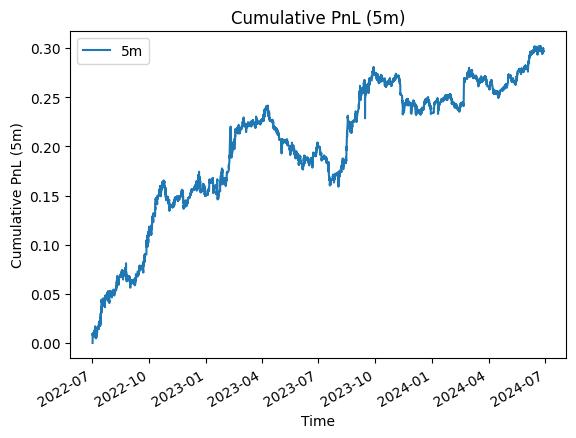

In [17]:
show_stats(res)

In [18]:
key = 'volume_imbalance'
WEIGHTS[key] = weights
PNL[key] = res['pnl_5m']
DRAWDOWN[key] = res['drawdown_5m']

Simple reversion

In [ ]:
returns = sim.get_data('trade_pr_close').pct_change()

weights = - returns
weights = weights.ewm(com=800).mean()

# restrict universe
weights = weights.where(sim.universe_5m['top_100'])

weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Annualized Sharpe (5m)      = 12.27
Profit Margin (bps, 5m)     = 9.24
Avg Turnover (5m)           = 0.05
Max Drawdown (5m)           = -0.19


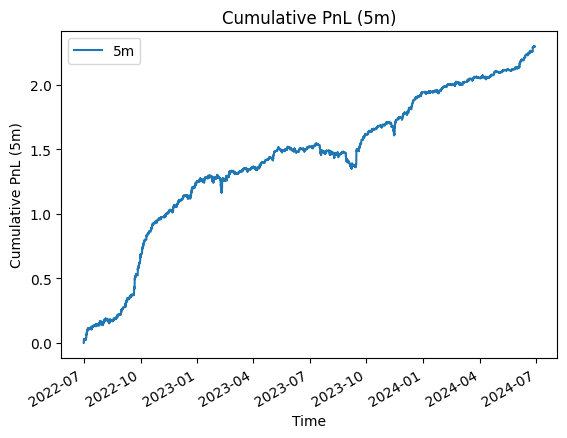

In [20]:
show_stats(res)

In [21]:
key = 'simple_reversion'
WEIGHTS[key] = weights
PNL[key] = res['pnl_5m']
DRAWDOWN[key] = res['drawdown_5m']

Reversion #2

In [ ]:
vwap = sim.get_data('trade_pr_vwap')
close = sim.get_data('trade_pr_close')

weights = vwap / close
weights = weights.ewm(com=250).mean()

weights = weights.where(sim.universe_5m['top_100'])

weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Annualized Sharpe (5m)      = 9.64
Profit Margin (bps, 5m)     = 6.0
Avg Turnover (5m)           = 0.05
Max Drawdown (5m)           = -0.12


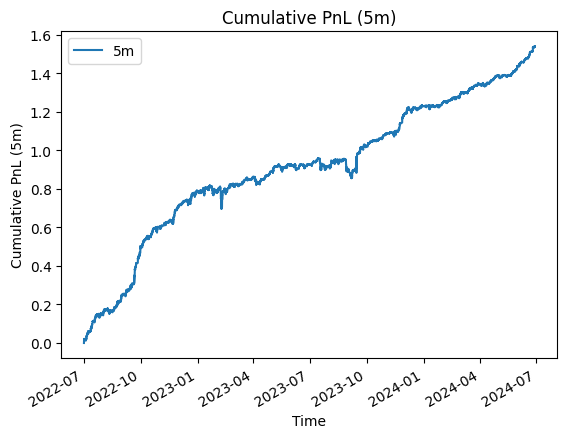

In [23]:
show_stats(res)

In [24]:
key = 'reversion_2'
WEIGHTS[key] = weights
PNL[key] = res['pnl_5m']
DRAWDOWN[key] = res['drawdown_5m']

Nikita #1

In [ ]:
high = sim.get_data('trade_pr_high')
low = sim.get_data('trade_pr_low')
vwap = sim.get_data('trade_pr_vwap')

weights = (high*low)**(0.5) / vwap - 1
weights = weights.ewm(com=160000).mean()
weights = weights.where(sim.universe_5m['top_100'])
weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Annualized Sharpe (5m)      = 4.41
Profit Margin (bps, 5m)     = 29.7
Avg Turnover (5m)           = 0.0
Max Drawdown (5m)           = -0.12


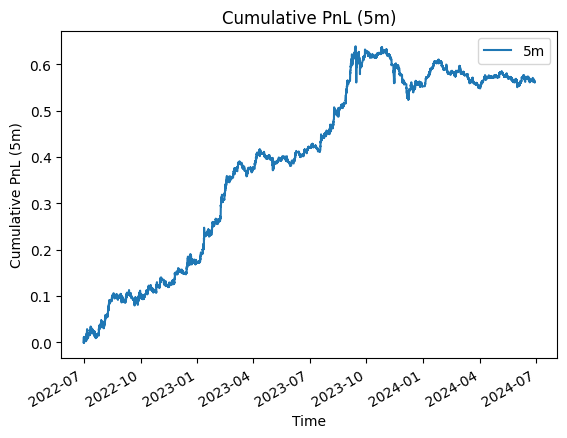

In [26]:
show_stats(res)

In [27]:
key = 'nikita_1'
WEIGHTS[key] = weights
PNL[key] = res['pnl_5m']
DRAWDOWN[key] = res['drawdown_5m']

Seryoga #2

In [ ]:
ob_val_b = sim.get_data('orderbook_val_b') 
ob_val_s = sim.get_data('orderbook_val_s') 
 
weights = (ob_val_b - ob_val_s) / (ob_val_b + ob_val_s) 
weights = weights.ewm(com=200).mean() 
weights = weights.where(sim.universe_5m['top_100']) 
weights = truncate_and_normalize(weights, 0.04) 
 
res = sim.run_weights(weights)

Annualized Sharpe (5m)      = 7.47
Profit Margin (bps, 5m)     = 34.1
Avg Turnover (5m)           = 0.0
Max Drawdown (5m)           = -0.07


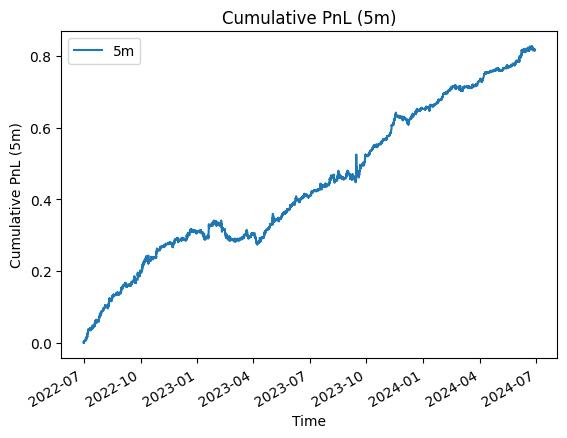

In [29]:
show_stats(res)

In [30]:
key = 'seryoga_2'
WEIGHTS[key] = weights
PNL[key] = res['pnl_5m']
DRAWDOWN[key] = res['drawdown_5m']

Nikita #3

In [ ]:
tr_val_b = sim.get_data('trade_vol_b')  
tr_val_s = sim.get_data('trade_vol_s')

weights = ts_rank(tr_val_s, 12*4) - ts_rank(tr_val_b, 12*4)

weights = weights.ewm(com=500000).mean() 
weights = weights.where(sim.universe_5m['top_100'])
weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Annualized Sharpe (5m)      = 3.37
Profit Margin (bps, 5m)     = 3.15
Avg Turnover (5m)           = 0.02
Max Drawdown (5m)           = -0.07


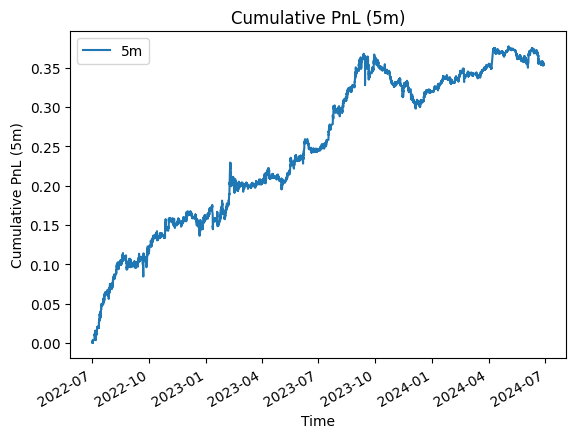

In [32]:
show_stats(res)

In [33]:
key = 'nikita_3'
WEIGHTS[key] = weights
PNL[key] = res['pnl_5m']
DRAWDOWN[key] = res['drawdown_5m']

Nikita #4

In [ ]:
order_put_val_b = sim.get_data('order_put_val_b')
order_put_val_s = sim.get_data('order_put_val_s')

weights = ts_zscore(order_put_val_s, 12*4) - ts_zscore(order_put_val_b, 12*4)

weights = weights.ewm(com=2000).mean() 
weights = weights.where(sim.universe_5m['top_100'])
weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Annualized Sharpe (5m)      = 2.61
Profit Margin (bps, 5m)     = 1.74
Avg Turnover (5m)           = 0.03
Max Drawdown (5m)           = -0.05


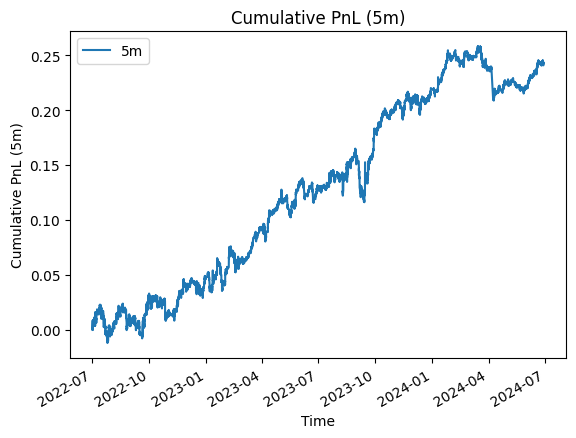

In [35]:
show_stats(res)

In [36]:
key = 'nikita_4'
WEIGHTS[key] = weights
PNL[key] = res['pnl_5m']
DRAWDOWN[key] = res['drawdown_5m']

Astemir #2

In [37]:
pr_vwap_ = sim.get_data('trade_pr_vwap')

left = pr_vwap_ - ts_min(pr_vwap_,12)

weights = - ts_rank(left,24)
weights = weights.ewm(com=5500).mean()
weights = weights.where(sim.universe_5m['top_100'])
weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Annualized Sharpe (5m)      = 4.53
Profit Margin (bps, 5m)     = 8.81
Avg Turnover (5m)           = 0.01
Max Drawdown (5m)           = -0.11


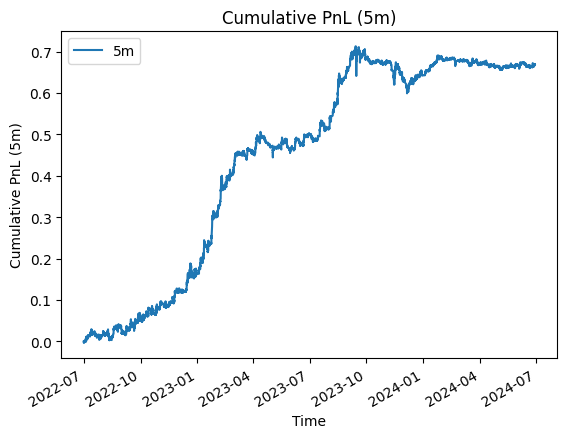

In [38]:
show_stats(res)

In [39]:
key = 'astemir_2'
WEIGHTS[key] = weights
PNL[key] = res['pnl_5m']
DRAWDOWN[key] = res['drawdown_5m']

Order put imbalance

In [ ]:
order_put_val_s = sim.get_data('order_put_val_s')
order_put_val = sim.get_data('order_put_val')

trade_val_s = sim.get_data('trade_val_s')
trade_val = sim.get_data('trade_val')

weights = order_put_val_s / order_put_val - 0.5
weights *= 1 + trade_val_s / trade_val

weights = weights.ewm(com=50).mean()  
weights = weights.where(sim.universe_5m['top_100'])  
weights = truncate_and_normalize(weights, 0.04)  
 
res = sim.run_weights(weights)

Annualized Sharpe (5m)      = 7.09
Profit Margin (bps, 5m)     = 2.51
Avg Turnover (5m)           = 0.05
Max Drawdown (5m)           = -0.04


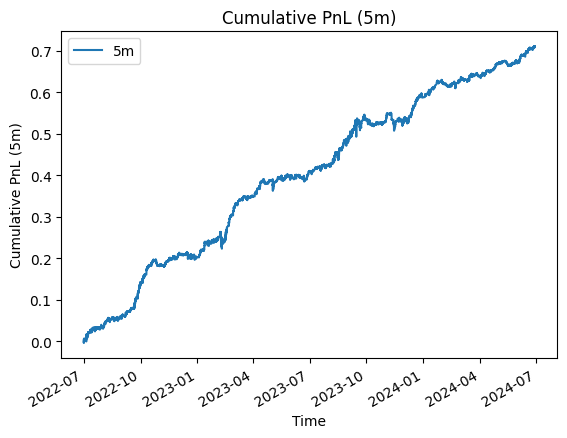

In [41]:
show_stats(res)

In [42]:
key = 'order_put_imbalance'
WEIGHTS[key] = weights
PNL[key] = res['pnl_5m']
DRAWDOWN[key] = res['drawdown_5m']

Cancellations vs puts

In [ ]:
order_cancel_val_b = sim.get_data('order_cancel_val_b')
order_cancel_val_s = sim.get_data('order_cancel_val_s')

order_put_val_b = sim.get_data('order_put_val_b')
order_put_val_s = sim.get_data('order_put_val_s')

trade_val_b = sim.get_data('trade_val_b')
trade_val = sim.get_data('trade_val')

weights = order_cancel_val_s / (order_cancel_val_s + order_put_val_s) - order_cancel_val_b / (order_cancel_val_b + order_put_val_b)
weights *= 1 + trade_val_b / trade_val

weights = weights.ewm(com=800).mean()

weights = weights.where(sim.universe_5m['top_100'])
weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Annualized Sharpe (5m)      = 4.8
Profit Margin (bps, 5m)     = 8.76
Avg Turnover (5m)           = 0.01
Max Drawdown (5m)           = -0.07


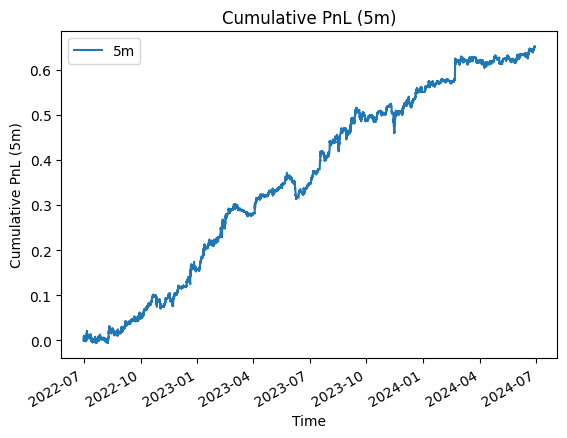

In [44]:
show_stats(res)

In [45]:
key = 'cancel_vs_put'
WEIGHTS[key] = weights
PNL[key] = res['pnl_5m']
DRAWDOWN[key] = res['drawdown_5m']

High low time

In [ ]:
trade_sec_pr_low = sim.get_data('trade_sec_pr_low')
trade_sec_pr_high = sim.get_data('trade_sec_pr_high')

trade_pr_low = sim.get_data('trade_pr_low')
trade_pr_high = sim.get_data('trade_pr_high')
trade_pr_close = sim.get_data('trade_pr_close')

weights = np.sign(trade_sec_pr_low - trade_sec_pr_high)

last_extr = (weights > 0) * trade_pr_low + (weights < 0) * trade_pr_high

weights *= 1 - (trade_pr_close / last_extr - 1).abs()

weights = weights.ewm(com=500).mean()

weights = weights.where(sim.universe_5m['top_100'])
weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Annualized Sharpe (5m)      = 5.78
Profit Margin (bps, 5m)     = 1.88
Avg Turnover (5m)           = 0.05
Max Drawdown (5m)           = -0.04


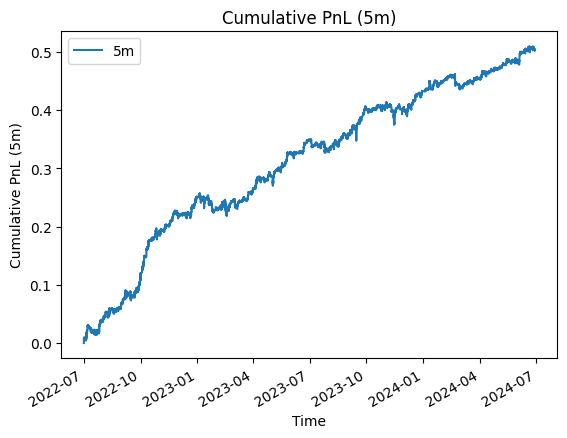

In [47]:
show_stats(res)

In [48]:
key = 'high_low_time'
WEIGHTS[key] = weights
PNL[key] = res['pnl_5m']
DRAWDOWN[key] = res['drawdown_5m']

---

### Correlations

In [49]:
pd.concat(PNL, axis=1).corr()

,volume_imbalance,simple_reversion,reversion_2,nikita_1,seryoga_2,nikita_3,nikita_4,astemir_2,order_put_imbalance,cancel_vs_put,high_low_time
volume_imbalance,1.000000,-0.104087,-0.024231,0.139478,-0.035598,0.118791,0.060153,0.231053,0.117067,-0.093855,-0.061542
simple_reversion,-0.104087,1.000000,0.529049,-0.251870,-0.136979,-0.128121,0.104013,-0.405129,0.250728,0.225019,0.347224
reversion_2,-0.024231,0.529049,1.000000,-0.397527,-0.085158,-0.174218,0.087764,-0.331545,0.203594,0.153499,0.093733
nikita_1,0.139478,-0.251870,-0.397527,1.000000,-0.240616,0.184390,-0.177343,0.495340,0.172160,0.062346,0.026234
seryoga_2,-0.035598,-0.136979,-0.085158,-0.240616,1.000000,-0.063853,0.104836,-0.194889,-0.337560,-0.151715,-0.186970
nikita_3,0.118791,-0.128121,-0.174218,0.184390,-0.063853,1.000000,-0.063985,0.177155,0.071978,-0.117946,0.065662
nikita_4,0.060153,0.104013,0.087764,-0.177343,0.104836,-0.063985,1.000000,-0.117857,0.088945,0.035415,0.052904
astemir_2,0.231053,-0.405129,-0.331545,0.495340,-0.194889,0.177155,-0.117857,1.000000,0.114063,-0.058826,-0.068392
order_put_imbalance,0.117067,0.250728,0.203594,0.172160,-0.337560,0.071978,0.088945,0.114063,1.000000,0.367834,0.161468
cancel_vs_put,-0.093855,0.225019,0.153499,0.062346,-0.151715,-0.117946,0.035415,-0.058826,0.367834,1.000000,0.057521


In [50]:
pd.concat(DRAWDOWN, axis=1).corr()

,volume_imbalance,simple_reversion,reversion_2,nikita_1,seryoga_2,nikita_3,nikita_4,astemir_2,order_put_imbalance,cancel_vs_put,high_low_time
volume_imbalance,1.000000,0.157385,0.119018,0.087753,-0.215905,0.168755,-0.181386,0.274040,0.175007,0.145351,0.017782
simple_reversion,0.157385,1.000000,0.815050,-0.270737,0.112090,-0.245340,0.130083,-0.254568,0.034464,0.034676,0.180489
reversion_2,0.119018,0.815050,1.000000,-0.295758,0.167960,-0.194842,0.091858,-0.267761,0.026065,-0.029139,0.265297
nikita_1,0.087753,-0.270737,-0.295758,1.000000,-0.217711,0.521172,0.308882,0.848314,0.124765,-0.065166,-0.073282
seryoga_2,-0.215905,0.112090,0.167960,-0.217711,1.000000,0.200837,-0.121705,-0.236207,-0.107769,-0.073462,0.162752
nikita_3,0.168755,-0.245340,-0.194842,0.521172,0.200837,1.000000,-0.256328,0.654935,0.342303,-0.014472,0.184298
nikita_4,-0.181386,0.130083,0.091858,0.308882,-0.121705,-0.256328,1.000000,0.143245,-0.140313,0.007740,-0.094861
astemir_2,0.274040,-0.254568,-0.267761,0.848314,-0.236207,0.654935,0.143245,1.000000,0.336008,0.039272,-0.060287
order_put_imbalance,0.175007,0.034464,0.026065,0.124765,-0.107769,0.342303,-0.140313,0.336008,1.000000,0.388057,0.171325
cancel_vs_put,0.145351,0.034676,-0.029139,-0.065166,-0.073462,-0.014472,0.007740,0.039272,0.388057,1.000000,-0.004755


---

### Equal-weighted combo

In [51]:
weights_concat = pd.concat(WEIGHTS, axis=1)

In [ ]:
combo_ew = weights_concat.fillna(0).groupby(level=1, axis=1).mean().where(weights_concat.notna().groupby(level=1, axis=1).any())
combo_ew = scale(combo_ew)

In [53]:
ew_weights = combo_ew.ewm(com=1).mean()
ew_weights = ew_weights.where(sim.universe_5m['top_100'])
ew_weights = truncate_and_normalize(ew_weights, 0.04)

In [54]:
ew_res = sim.run_weights(ew_weights)

Annualized Sharpe (5m)      = 13.65
Profit Margin (bps, 5m)     = 8.63
Avg Turnover (5m)           = 0.03
Max Drawdown (5m)           = -0.08


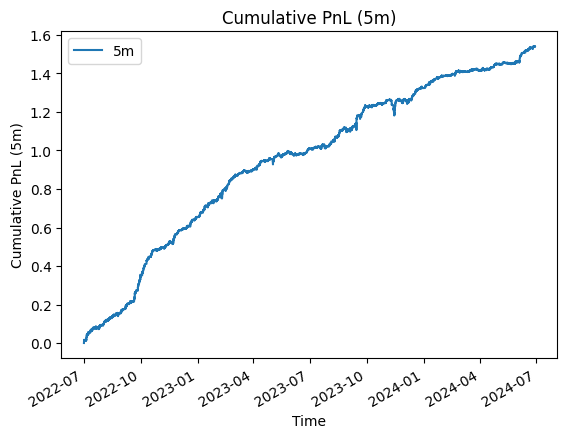

In [55]:
show_stats(ew_res)

### MARKOWITZ

In [56]:
def sharpe(pnl): 
      return np.sqrt(365) * pnl.mean() / pnl.std()

In [57]:
drawdown_5m = pd.DataFrame({
    wname: (returns * w.shift()).sum(axis=1).cumsum() - ((returns * w.shift()).sum(axis=1).cumsum()).cummax()
    for wname, w in WEIGHTS.items()
})
drawdown_5m = drawdown_5m.resample('5min').sum()

In [58]:
drawdown_5m

,volume_imbalance,simple_reversion,reversion_2,nikita_1,seryoga_2,nikita_3,nikita_4,astemir_2,order_put_imbalance,cancel_vs_put,high_low_time
2022-07-01 10:05:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-07-01 10:10:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-07-01 10:15:00,0.000000,0.000000,0.000000,0.000000,-0.001553,0.000000,0.000000,0.000000,-0.000142,0.000000,-0.000253
2022-07-01 10:20:00,0.000000,0.000000,0.000000,0.000000,-0.000816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-07-01 10:25:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000375,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28 18:20:00,-0.005520,-0.000277,0.000000,-0.077073,-0.012038,-0.022910,-0.014771,-0.041979,-0.000630,-0.000278,-0.005939
2024-06-28 18:25:00,-0.005292,0.000000,0.000000,-0.077307,-0.012065,-0.022736,-0.014263,-0.042051,-0.000202,-0.000118,-0.005829
2024-06-28 18:30:00,-0.005359,0.000000,0.000000,-0.077234,-0.012095,-0.022841,-0.014870,-0.042219,-0.000453,-0.000380,-0.005816
2024-06-28 18:35:00,-0.005210,-0.000005,-0.000045,-0.077288,-0.012034,-0.022569,-0.014813,-0.042367,-0.000458,-0.000644,-0.005684


In [59]:
ndays = 63
solution = dict()

In [60]:
drawdown_5m.shape[0]

209768

In [ ]:
for dti in tqdm(list(range(ndays * 104 - 1, drawdown_5m.shape[0], 104))):
    start_dt = drawdown_5m.index[dti - (ndays * 104) + 1]
    end_dt = drawdown_5m.index[dti]
    
    P = 1e3 * drawdown_5m.loc[start_dt:end_dt]

    alpha_names = P.columns
    n = alpha_names.size
    
    m = P.mean().values
    sigma = P.cov().values
    
    if np.linalg.cond(sigma) > 1e10:  
        sigma += 1e-5 * np.eye(n) 

    c_ew = np.repeat(1 / n, n)
    a_ew = np.dot(c_ew, m) / c_ew.dot(sigma).dot(c_ew)

    a = 2 * a_ew

    w = cp.Variable(n, nonneg=True)

    constraints = [
        cp.sum(w) == 1 
    ]

    p = cp.Problem(
        cp.Maximize(m @ w - a * cp.quad_form(w, sigma)),
        constraints
    )
    
    try:
        p.solve()
        if p.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
            raise ValueError("Solver did not converge")
        solution[end_dt] = pd.Series(w.value, index=alpha_names)
    except Exception as e:
        print(f"{end_dt}: Optimization failed ({str(e)})")
        solution[end_dt] = pd.Series(1 / n, index=alpha_names)

In [62]:
alpha_weights = pd.concat(solution, axis=0).unstack(level=1).shift().reindex(index=sim.dates)
alpha_weights.index = alpha_weights.index.map(lambda x: pd.to_datetime(x) + pd.Timedelta(sim.session_start_time) + pd.Timedelta(minutes=5))
alpha_weights = alpha_weights.reindex(index=sim.timeline_5m).ffill()

In [ ]:
opt_weights = weights_concat.mul(alpha_weights, level=0).groupby(level=1, axis=1).sum().where(weights_concat.notnull().groupby(level=1, axis=1).max())
opt_weights = opt_weights.div(opt_weights.abs().sum(axis=1), axis=0)

In [64]:
opt_weights_1 = opt_weights.copy()
opt_weights_1 = opt_weights_1.ewm(com=0.35).mean()

In [65]:
opt_weights_1 = opt_weights_1.where(sim.universe_5m['top_100'])
opt_weights_1 = truncate_and_normalize(opt_weights_1, 0.04)

In [66]:
opt_res = sim.run_weights(opt_weights_1, start_date='2022-10-01')

Annualized Sharpe (5m)      = 15.47
Profit Margin (bps, 5m)     = 7.77
Avg Turnover (5m)           = 0.04
Max Drawdown (5m)           = -0.08


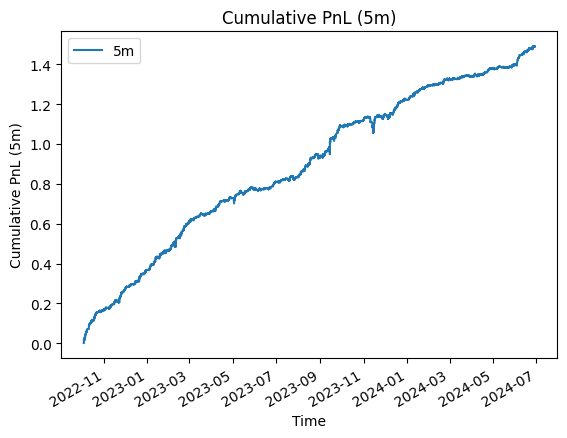

In [67]:
show_stats(opt_res)

In [68]:
ew_res = sim.run_weights(ew_weights, start_date='2022-10-01')

Annualized Sharpe (5m)      = 12.41
Profit Margin (bps, 5m)     = 7.81
Avg Turnover (5m)           = 0.03
Max Drawdown (5m)           = -0.08


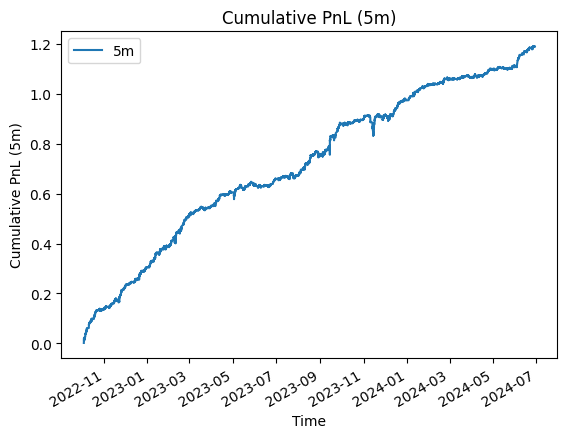

In [69]:
show_stats(ew_res)